# Source code for ICLR Reproducibility Challenge

### Load packages

In [1]:
import matplotlib.pyplot as plt
from torchvision import *
import torch as pt
import numpy as np

DEVICE = 'cuda'

### Load data from disk

In [2]:
data = np.load('mnist.npz')
mnist_full_x = np.concatenate([data['train_data'], data['test_data']])
mnist_full_y = np.concatenate([data['train_labels'], data['test_labels']])

In [3]:
'''
Loader code
it splits the data into training and validation set
it returns two generators
'''

def RamLoad(dataset, labels, split=1, batch_size=1,
                   t_trans=transforms.Compose([]), v_trans=transforms.Compose([])):
    
    class RamLoader(pt.utils.data.DataLoader): 
        def __init__(self, data, labels, transform, **kwargs):
            super().__init__(pt.utils.data.TensorDataset(data,labels), **kwargs)
            self.dataset.transform = transform
    
    indices = pt.randperm(dataset.shape[0])
    split_point = int(split*dataset.shape[0])
    train_data = dataset[ indices[:split_point] ]; train_labels= labels[ indices[:split_point] ]
    valid_data = dataset[ indices[split_point:] ]; valid_labels= labels[ indices[split_point:] ]
    
    return {'train':RamLoader(train_data, train_labels, transform=t_trans, batch_size=batch_size, shuffle=True),
            'eval' :RamLoader(valid_data, valid_labels, transform=v_trans, batch_size=batch_size, shuffle=False)}

In [4]:
'''
Useful data transformations
'''

class TransformFlatten:
    def __call__(self, x):
        return x.view(x.shape[0], -1)
    
class TransformStandarize:
    def __init__(self, mean=0, std=1):
        self.mean, self.std = mean, std
    def __call__(self, x):
        return (x - pt.mean(x) + self.mean) / pt.std(x) * self.std

In [5]:
'''
Data is ready from here
'''

tmnist_x = TransformStandarize()(pt.tensor(mnist_full_x, device=DEVICE, dtype=pt.float))
tmnist_y = pt.tensor(mnist_full_y, device=DEVICE, dtype=pt.long)

RamLoader = RamLoad(tmnist_x, tmnist_y, split=0.85, batch_size=128)

# Neural network code

In [33]:
l = LayerFlatten()

In [42]:
import time

'''
One can flatten the data before sending to classifier
And thicken to ensure that it has depth to go through convolutional layers
'''

class LayerFlatten(pt.nn.Module):
    def forward(self, x): return x.view(x.shape[0], -1)
    
class LayerThicken(pt.nn.Module):
    def forward(self, x):
        if x.dim()==4:
            if x.shape[-1]==3 or x.shape[-1]==1:
                x = x.transpose(1,-1)
            return x
        if x.dim()==3:
            return x[:,None,:,:]
        if x.dim()==2:
            n, m = x.shape
            return x[n, None, int(m**0.5), m-int(m**0.5)]

class NN:
    def __init__(self, model, device): # nn = NN(model, prepr, 'cpu')
        super().__init__()
        self.model = model.to(device)
        self.device = device
        self.epoch = 0
        
        # DEFAULTS
        self.optim = pt.optim.SGD(params=model.parameters(), lr=0.1)
        self.scheduler = pt.optim.lr_scheduler.ExponentialLR(self.optim, gamma=0.99)
    
    def fit(self, data_loader, loss, silent=False, s_report=100, v_report=1, max_epochs=float('inf'), loop_operation=[]):
        try:
            if not silent:
                print("TRAINING:\n{:<10} | {:<10} | {:<12} - {}\n".format\
                      ('epoch', 'time', 'error rate', 'mistakes...'))
            
            i, result = 0, 0
            self.stime = time.time()
            eval_length = data_loader['eval'].dataset.__len__()
            history = {'train':{'i':[], 'e':[], 'l':[]}, 'eval':{'i':[], 'e':[]}}
            self.scheduler.last_epoch = self.epoch-1
            
            while True:
                self.scheduler.step()
                if not self.epoch % v_report:
                    res = self.evaluate(data_loader['eval'], eval_length, result, silent)
                    history['eval']['e'].append(float(res)); history['eval']['i'].append(i)
                    
                self.epoch+=1
                self.model.train()
                for x, y in data_loader['train']:
                    self.optim.zero_grad()
                    x = self.model.forward(x)
                    L = loss(x, y)
                    i+=1
                    
                    L.backward()
                    with pt.no_grad():
                        self.optim.step()
                        result = pt.sum(pt.argmax(x, dim=-1)==y, dtype=pt.float)/x.shape[0]
                        for op in loop_operation: op() # You can run some additional, outside functions here running every iteration
                           
                    if not i%s_report:
                        history['train']['e'].append(float(100-100*result))
                        history['train']['l'].append(float(L)); history['train']['i'].append(i)
                        if not silent: self.report(i, L, result)
                        
    
                    
                if self.epoch>=max_epochs: break
        except KeyboardInterrupt: pass
        res = self.evaluate(data_loader['eval'], eval_length, result, silent)
        history['eval']['e'].append(float(res)); history['eval']['i'].append(i)
        if not silent:
            self.draw_history(history)
        return history
    
    def report(self, iteration, loss, error):
        print( "Iter {:>5} | err {:>5.2f}% | loss {:<5.3f}".format(iteration, 100-100*error, loss), end='\r' )
    
    def evaluate(self, data_loader, eval_length, train_error, silent=False):
        self.model.eval()
        with pt.no_grad():
            result = pt.tensor(0.)
            for x, y in data_loader:
                x = self.model.forward(x)
                predicts = pt.argmax(x, dim=-1)
                result += pt.sum(y==predicts)
        if not silent:
            print( "Epoch {:>4} | time {:0<5.3} | lr {:0<7.4} | tr {:>7.3f}% | eval {:>6.3f}% - {} mis".format( self.epoch,
                    time.time()-self.stime, self.optim.param_groups[0]['lr'],
                                                                100-100*train_error, 100-100*result/eval_length, int(eval_length-result)))
        self.stime = time.time()
        return 100 - 100*result/eval_length
        
    def predict(self, data, answers=None, silent=False):
        self.model.eval()
        with pt.no_grad():
            x = self.model.forward(data)
            x = pt.argmax(x, dim=-1)
        if answers is None: return x
        res = pt.sum(x==answers, dtype=pt.float) / x.shape[0]
        if not silent: print("Accuracy: {:>6.3f}%".format(100 * res))
        return float(res)
    
    def draw_history(self, history):
        print('\n'); plt.figure(figsize=(15,4)); plt.subplot(121)
        plt.plot(history['train']['i'], history['train']['l'])
        plt.xlabel('iterations'); plt.ylabel('training loss'); plt.grid(True, linewidth=0.2); plt.subplot(122)
        plt.plot(history['eval']['i'][1:], history['eval']['e'][1:], label='evaluation')
        plt.plot(history['train']['i'][1:], history['train']['e'][1:], label='training')
        plt.xlabel('iterations'); plt.ylabel('errors'); plt.grid(True, linewidth=0.2); plt.legend()

# Pruner

Please note that:
$\frac{\partial L}{\partial c_j} = \frac{\partial L}{\partial w_j} \cdot w_j$. This formula was used to simplify the calculations.

In [61]:
class Pruner:
    def __init__(self, model, loader=None, device='cpu', silent=False):
        self.device = device
        self.loader = loader
        self.model = model
        
#         self.weights = list(model.parameters())

        self.weights = []
        for layer in model:
            try:
                self.weights.append(layer.weight)
            except AttributeError:
                pass

        self.indicators = [pt.ones_like(layer) for layer in self.weights]
        self.pruned = [0 for _ in range(len(self.indicators))]
 
        if not silent:
            print("number of weights to prune:", [x.numel() for x in self.indicators])

    def indicate(self):
        for weight, indicator in zip(self.weights, self.indicators):
            weight.data = weight * indicator
       
    
    def snip(self, sparsity, mini_batches=1, silent=False): # prunes due to SNIP method
        mini_batch=0
        self.indicate()
        self.model.zero_grad()
        grads = [pt.zeros_like(w) for w in self.weights]
        
        for x, y in self.loader:
            x = self.model.forward(x)
            L = pt.nn.CrossEntropyLoss()(x, y)
            grads = [g.abs()+ag.abs() for g, ag in zip(grads, pt.autograd.grad(L, self.weights))]
            mini_batch+=1
            if mini_batch>=mini_batches: break

        with pt.no_grad():
            saliences = [(grad * weight).view(-1).abs().cpu() for weight, grad in zip(self.weights, grads)]
            saliences = pt.cat(saliences)
            
            thresh = float( saliences.kthvalue( int(sparsity * saliences.shape[0] ) )[0] )
            
            for j, layer in enumerate(self.indicators):
                layer[ (grads[j] * self.weights[j]).abs() <= thresh ] = 0
                self.pruned[j] = int(pt.sum(layer == 0))
        self.model.zero_grad() 
        
        if not silent:
            print("weights left: ", [self.indicators[i].numel()-pruned for i, pruned in enumerate(self.pruned)],
                  "sparsities: ", [round(100*pruned/self.indicators[i].numel(), 2) for i, pruned in enumerate(self.pruned)])
            
            
    def snipR(self, sparsity, silent=False):
        with pt.no_grad():
            saliences = [pt.zeros_like(w) for w in self.weights]
            x, y = next(iter(self.loader))
            z = self.model.forward(x)
            L0 = pt.nn.CrossEntropyLoss()(z, y) # Loss

            for laynum, layer in enumerate(self.weights):
                if not silent: print("layer ", laynum, "...")
                for weight in range(layer.numel()):
                    temp = layer.view(-1)[weight].clone()
                    layer.view(-1)[weight] = 0

                    z = self.model.forward(x) # Forward pass
                    L = pt.nn.CrossEntropyLoss()(z, y) # Loss
                    saliences[laynum].view(-1)[weight] = (L-L0).abs()    
                    layer.view(-1)[weight] = temp
                
            saliences_bag = pt.cat([s.view(-1) for s in saliences]).cpu()
            thresh = float( saliences_bag.kthvalue( int(sparsity * saliences_bag.numel() ) )[0] )

            for j, layer in enumerate(self.indicators):
                layer[ saliences[j] <= thresh ] = 0
                self.pruned[j] = int(pt.sum(layer == 0))   
        
        if not silent:
            print("weights left: ", [self.indicators[i].numel()-pruned for i, pruned in enumerate(self.pruned)],
                  "sparsities: ", [round(100*pruned/self.indicators[i].numel(), 2) for i, pruned in enumerate(self.pruned)])

# Model definitions

In [62]:
def LeNet_300_100():
    model = pt.nn.Sequential(
        LayerFlatten(),
        pt.nn.Linear(784, 300),
        pt.nn.ReLU(),
        pt.nn.Linear(300, 100),
        pt.nn.ReLU(),
        pt.nn.Linear(100, 10),
        pt.nn.LogSoftmax(dim=-1))
    return model

In [63]:
def LeNet5(init=None):
    model = pt.nn.Sequential(
        LayerThicken(), 
        pt.nn.Conv2d(1, 6, kernel_size=5, padding=2),
        pt.nn.ReLU(),
        pt.nn.MaxPool2d(kernel_size=2),
        pt.nn.Conv2d(6, 16, kernel_size=5),
        pt.nn.ReLU(),
        pt.nn.MaxPool2d(kernel_size=2),
        LayerFlatten(),
        pt.nn.Linear(400,120),
        pt.nn.ReLU(),
        pt.nn.Linear(120, 84),
        pt.nn.ReLU(),
        pt.nn.Linear(84, 10),
        pt.nn.LogSoftmax(dim=-1))
    return model

In [72]:
def vgg16():
    vgg = models.vgg16_bn()
    vgg.features[0] = pt.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    vgg.classifier = pt.nn.Sequential(
        pt.nn.Linear(512, 300),
        pt.nn.ReLU(),
        pt.nn.BatchNorm1d(300),
        pt.nn.Linear(300,10),
        pt.nn.LogSoftmax(dim=-1))
    model = pt.nn.Sequential( LayerThicken(), *vgg.features , LayerFlatten(), *vgg.classifier )
    return model

# Network training - example

In [76]:
model = LeNet_300_100()
nn = NN(model, DEVICE)

prune = Pruner(model, RamLoader['train'], DEVICE, silent=False)
prune.snip(0.99)
prune.indicate()

number of weights to prune: [235200, 30000, 1000]
weights left:  [828, 1453, 381] sparsities:  [99.65, 95.16, 61.9]


In [78]:
params = list(model.parameters())[0].reshape(-1).cpu().detach().numpy()

In [79]:
params = params[params!=0]

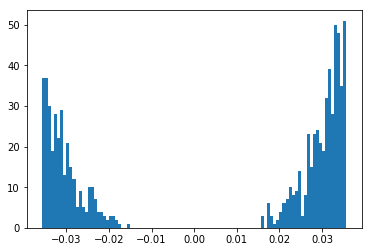

In [80]:
plt.hist( params, bins=100 );

number of weights to prune: [235200, 30000, 1000]
weights left:  [809, 1459, 394] sparsities:  [99.66, 95.14, 60.6]
TRAINING:
epoch      | time       | error rate   - mistakes...

Epoch    0 | time 0.0846 | lr 0.10000 | tr 100.000% | eval 87.286% - 9165 mis
Epoch    5 | time 3.870 | lr 0.10000 | tr   4.630% | eval  7.905% - 830 mis
Epoch   10 | time 3.900 | lr 0.10000 | tr   3.704% | eval  6.838% - 718 mis
Epoch   15 | time 4.060 | lr 0.10000 | tr   7.407% | eval  6.229% - 654 mis
Epoch   20 | time 3.950 | lr 0.10000 | tr   5.556% | eval  6.552% - 688 mis
Epoch   25 | time 4.190 | lr 0.10000 | tr   5.556% | eval  6.381% - 670 mis
Epoch   30 | time 3.960 | lr 0.10000 | tr   6.481% | eval  6.143% - 645 mis
Epoch   35 | time 4.020 | lr 0.10000 | tr   4.630% | eval  6.619% - 695 mis
Epoch   40 | time 3.960 | lr 0.01000 | tr   2.778% | eval  6.571% - 690 mis
Epoch   45 | time 3.890 | lr 0.01000 | tr   4.630% | eval  5.086% - 534 mis
Epoch   50 | time 3.960 | lr 0.01000 | tr   3.704% | eval 

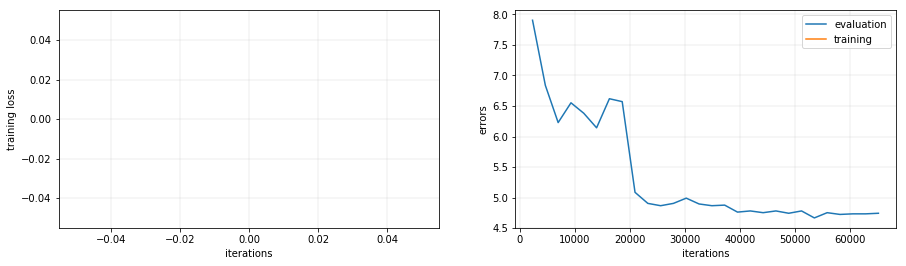

In [75]:
model = LeNet_300_100()
nn = NN(model, DEVICE)

prune = Pruner(model, RamLoader['train'], DEVICE, silent=False)
prune.snip(0.99)

loop_operation=[prune.indicate]

nn.optim = pt.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9, weight_decay=0.0005)
nn.scheduler = pt.optim.lr_scheduler.StepLR(nn.optim, step_size=40, gamma=0.1)

hist = nn.fit( RamLoader, pt.nn.CrossEntropyLoss(), s_report=float('inf'), v_report=5, max_epochs=140, silent=False, loop_operation=loop_operation)